In [31]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import csv


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

In [10]:
# Global parameters

radius_range = np.arange(0.5,1.6,0.5)

with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)

point_collection_indices = np.arange(len(new_contiguous_point_collection))
point_collection_indices

array([0, 1, 2, 3, 4, 5, 6])

# Step 1 Getting sample points for one-time partial radius

Done generating 1000 samples in 0.123 seconds.


(array([153., 138., 141., 137., 136., 150., 145.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

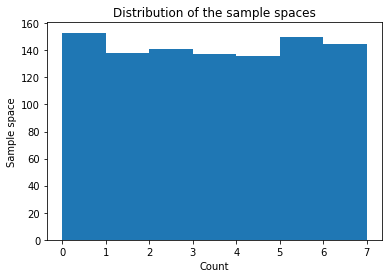

In [22]:
samples = 1000

sample_points = []

samples_indeces = []

t0 = time.time()

for i in np.arange(samples):

    random_object = np.random.choice(point_collection_indices)

    object_name = new_contiguous_point_collection[random_object][0]
    pointCloud = new_contiguous_point_collection[random_object][1]
    triangles = new_contiguous_point_collection[random_object][2]
    
    triangle_index = np.random.choice(np.arange(len(triangles)))
    vertex_index = triangles[triangle_index,1]
    original_vertex = pointCloud[vertex_index]

    sample_points.append([
        random_object, 
        object_name, 
        original_vertex
    ])
    
    samples_indeces.append(random_object)
    
print("Done generating",len(sample_points),"samples in {:.3f} seconds.".format(time.time()-t0))

with open('sample_points.pickle','wb') as f:
    pickle.dump(sample_points,f)
    
plt.title("Distribution of the sample spaces")
plt.xlabel("Count")
plt.ylabel("Sample space")
plt.hist(samples_indeces,bins = np.arange(0,8))


# Step 2 Creating a synthetic set of successive partial spaces

Similar to the partial case above, we use the same sample points, i.e. centroids, for successive releases but will only vary the size of the partial space for every release.


In [26]:

samples = 100
releases = 100

nearby_range = 2.0
    
t1 = time.time()

successive_sample_points = []

for i in np.arange(samples):#

    random_object = np.random.choice(point_collection_indices)
    #reference_ransac = np.random.randint(5)

    object_name = new_contiguous_point_collection[random_object][0]
    pointCloud = new_contiguous_point_collection[random_object][1]
    triangles = new_contiguous_point_collection[random_object][2]

    current_vertex = pointCloud[np.random.randint(len(pointCloud))]

    growing_point_collection_vertices = [[
        random_object, 
        object_name, 
        current_vertex
    ]]

    nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud)),algorithm='kd_tree').fit(pointCloud[:,:3])

    for release in np.arange(releases-1):

        distances, indices = nbrs.kneighbors([current_vertex[:3]])

        cand_indices = indices[0,np.where(distances[0]<(nearby_range))[0]]

        distribution = np.sort(abs(np.random.normal(nearby_range*0.5,nearby_range*0.3,len(cand_indices))))

        current_vertex = pointCloud[
            np.random.choice(
                cand_indices,
                p = distribution/np.sum(distribution)
            )
        ]

        growing_point_collection_vertices.append([
            random_object, 
            object_name, 
            current_vertex
        ])

    successive_sample_points.append([
        [random_object, object_name],
        growing_point_collection_vertices
    ])

    if i % 33 == 1:
        print(" Done with successive {} sample_points extraction in {:.3f} seconds".format(i,time.time()-t1))
        t1 = time.time()

    with open('successive_sample_points.pickle','wb') as f:
        pickle.dump(successive_sample_points,f)


 Done with successive 1 sample_points extraction for radius 0.5 in 1.080 seconds
 Done with successive 34 sample_points extraction for radius 0.5 in 18.763 seconds
 Done with successive 67 sample_points extraction for radius 0.5 in 18.948 seconds


In [29]:

t1 = time.time()

try:
    with open('successive_sample_points.pickle','rb') as f:
        successive_point_collection = pickle.load(f)

    samples = len(successive_point_collection)
    releases = len(successive_point_collection[0][1])

    print(samples,"samples for radius",radius)
    print(releases,"releases each")

except Exception as e1:
    print(e1)

successive_sample_points_per_release = [[]]

for k, [obj_, growing_point_collection] in enumerate(successive_point_collection):

    t2 = time.time()

    successive_sample_points = []

    reference_ransac = np.random.randint(5)

    for i, obj_meta in enumerate(growing_point_collection):

        successive_sample_points.append([obj_meta, reference_ransac])

        try:
            successive_sample_points_per_release[i].append(successive_sample_points)
        except:
            successive_sample_points_per_release.append([successive_sample_points])

        #print(len(successive_sample_points_per_release[i]),len(successive_sample_points_per_release[i][k]))

    with open('successive_sample_points_per_release.pickle','wb') as f:
        pickle.dump(successive_sample_points_per_release,f)

print(" Done with successive sample_points extraction in {:.3f} seconds".format(time.time()-t1))
    

100 samples for radius 0.5
100 releases each
 Done with successive sample_points extraction in 2.226 seconds


# Step 3: Create submaps for pointnetvlad using same partial samples

In [33]:

baseline_path = 'pointnetvlad_submaps/partials/'

spatial_span = 2.0

interval = 0.5

num_points = 4096

partial_lengths = []

cutoff = 0.5

for radius in np.arange(0.25,3.1,0.25):
    
    per_radius_partial_length = []
    
    t1 = time.time()
            
    partial_path = os.path.join(baseline_path,"raw_partial_radius_"+str(radius)+"_"+str(num_points))+"_unassisted"
    pointcloud_partial_path = os.path.join(partial_path,"pointcloud_4m")
    #pointcloud_partial_bin_path = os.path.join(partial_path,"pointcloud_4m_npy")

    if not os.path.exists(partial_path): os.mkdir(partial_path)
    if not os.path.exists(pointcloud_partial_path): os.mkdir(pointcloud_partial_path)
    #if not os.path.exists(pointcloud_partial_bin_path): os.mkdir(pointcloud_partial_bin_path)

    print(" ",pointcloud_partial_path)
    #"""
    csvfile = open(partial_path+"/pointcloud_centroids_4m.csv",'w',newline = '')

    csv_writer = csv.writer(csvfile, delimiter = ',')
    csv_writer.writerow(['timestamp', 'northing', 'easting', 'alting'])
    #"""
    count = 0
    
    for obj_, object_name, original_vertex in sample_points:
        
        new_partial_pointcloud = []
        new_vX = []
        new_vZ = []
        
        try:

            object_, ransac_pointCloud, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        if object_name == "Reception-Data61-L5.obj":
            new_X = pointCloud[:,0] + 50
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] + 50
            new_vZ = original_vertex[2] + 0
        elif object_name == "Driveway.obj":
            new_X = pointCloud[:,0] - 25
            new_Z = pointCloud[:,2] - 50
            new_vX = original_vertex[0] - 25
            new_vZ = original_vertex[2] - 50
        elif object_name == "Apartment.obj":
            new_X = pointCloud[:,0] + 25
            new_Z = pointCloud[:,2] - 50
            new_vX = original_vertex[0] + 25
            new_vZ = original_vertex[2] - 50
        elif object_name == "Workstations-Data61-L4.obj":
            new_X = pointCloud[:,0] - 50
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] - 50
            new_vZ = original_vertex[2] + 0
        elif object_name == "Kitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] + 0
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] + 0
            new_vZ = original_vertex[2] + 0
        elif object_name == "HallWayToKitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] - 25
            new_Z = pointCloud[:,2] + 50
            new_vX = original_vertex[0] - 25
            new_vZ = original_vertex[2] + 50
        elif object_name == "StairWell-Data61-L4.obj":
            new_X = pointCloud[:,0] + 25
            new_Z = pointCloud[:,2] + 50
            new_vX = original_vertex[0] + 25
            new_vZ = original_vertex[2] + 50
        else:
            print("Error:",obj_meta)

        new_Y = pointCloud[:,1]

        new_partial_pointcloud = np.stack((new_X,new_Z,new_Y)).T
        
        max_known_span = max(np.amax(new_partial_pointcloud, axis = 0) - np.amin(new_partial_pointcloud, axis = 0))
        
        nbrs = NearestNeighbors(n_neighbors=min(2*num_points,len(new_partial_pointcloud)), algorithm='kd_tree').fit(new_partial_pointcloud)

        # Get submap "centroids" by quantizing by 0.25m, i.e. round then unique
        if max_known_span > 2*spatial_span:
            round_new_partial_pointcloud = 100*np.around(0.01*new_partial_pointcloud,decimals=2)
            unq_round_partial_pointcloud = np.unique(round_new_partial_pointcloud[:,:3],axis = 0)
        #    
            raw_partial_centroids = unq_round_partial_pointcloud
            c_nbrs = NearestNeighbors(n_neighbors = min(25,len(raw_partial_centroids)),  algorithm='kd_tree').fit(raw_partial_centroids)
            c_dist, c_ind = c_nbrs.kneighbors(raw_partial_centroids)

            ia1, ia2 = np.where(c_dist < 1.73)
            

            dist_bins = np.bincount(ia1)
            max_dist = max(np.bincount(ia1))
            raw_partial_centroids = raw_partial_centroids[[i for i, j in enumerate(dist_bins) if j == max_dist]]
            
            raw_partial_centroids = raw_partial_centroids+np.random.normal(0,interval,raw_partial_centroids.shape)
            
        else:
            # Correcting this, because the attacker is supposed to not know the true centroid
            # and has to estimate it instead.
            #raw_partial_centroids = [[new_vX, new_vZ, original_vertex[1]]]        

            raw_partial_centroids = [np.mean(new_partial_pointcloud, axis = 0)]
            
        for northing, easting, alting in raw_partial_centroids:
            
            # Getting the points around our centroid defined by [northing, easting]
            distances, indices = nbrs.kneighbors([[northing, easting, alting]])
            
            #if max(distances[0]) < 0.5*spatial_span: continue
                
            submap_pointcloud = new_partial_pointcloud[indices[0,np.where(distances[0,:]<=spatial_span)[0]]]

            if len(submap_pointcloud) == 0:
                continue
            
            # Centering and rescaling
            submap_pointcloud = (submap_pointcloud - [northing, easting, alting])/spatial_span
            per_radius_partial_length.append([northing, easting, alting, len(submap_pointcloud)])

            if len(submap_pointcloud) > num_points:
                submap_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points)]
            elif len(submap_pointcloud) < num_points and len(submap_pointcloud) >= cutoff*num_points :
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud))]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)
            elif len(submap_pointcloud) < cutoff*num_points :
                #continue
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud), True)]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)

            timestamp = int(10**16*(time.time()))
            

            csv_writer.writerow([timestamp,northing,easting,alting,obj_])
            
            with open(pointcloud_partial_path+'/{}.pickle'.format(timestamp),'wb') as f:
                pickle.dump(submap_pointcloud.T,f)

            count += 1

            """
            with open("pnvlad/pointcloud_4m_0.25overlap/raw_{:05d}.bin".format(i),'wb') as byteFile:
                byteFile.write(bytes(np.asarray(submap_pointcloud.T,dtype=np.double)))

            """
            
    partial_lengths.append([
        radius,
        per_radius_partial_length
    ])

    print("   Done with submap generation for radius {} ( {} samples) in {:.3f} seconds".format(radius,count,time.time()-t1))
    #print(len(partial_lengths))
    csvfile.close()
       

  pointnetvlad_submaps/partials/raw_partial_radius_0.25_4096_unassisted/pointcloud_4m
   Done with submap generation for radius 0.25 ( 1000 samples) in 31.371 seconds
  pointnetvlad_submaps/partials/raw_partial_radius_0.5_4096_unassisted/pointcloud_4m
   Done with submap generation for radius 0.5 ( 1000 samples) in 32.118 seconds
  pointnetvlad_submaps/partials/raw_partial_radius_0.75_4096_unassisted/pointcloud_4m
   Done with submap generation for radius 0.75 ( 1000 samples) in 31.097 seconds
  pointnetvlad_submaps/partials/raw_partial_radius_1.0_4096_unassisted/pointcloud_4m
   Done with submap generation for radius 1.75 ( 1000 samples) in 32.356 seconds
  pointnetvlad_submaps/partials/raw_partial_radius_2.0_4096_unassisted/pointcloud_4m
   Done with submap generation for radius 2.0 ( 1000 samples) in 32.939 seconds
  pointnetvlad_submaps/partials/raw_partial_radius_2.25_4096_unassisted/pointcloud_4m
   Done with submap generation for radius 2.25 ( 1773 samples) in 40.771 seconds
  p

In [32]:

baseline_path = 'pointnetvlad_submaps/partials/'

spatial_span = 2.0

interval = 0.5

num_points = 4096

ransac_partial_lengths = []

cutoff = 0.5

for radius in np.arange(0.25,3.1,0.25):
    
    per_radius_partial_length = []
    
    t1 = time.time()
            
    partial_path = os.path.join(baseline_path,"ransac_partial_radius_"+str(radius)+"_"+str(num_points))+"_unassisted"
    pointcloud_partial_path = os.path.join(partial_path,"pointcloud_4m")
    #pointcloud_partial_bin_path = os.path.join(partial_path,"pointcloud_4m_npy")

    if not os.path.exists(partial_path): os.mkdir(partial_path)
    if not os.path.exists(pointcloud_partial_path): os.mkdir(pointcloud_partial_path)
    #if not os.path.exists(pointcloud_partial_bin_path): os.mkdir(pointcloud_partial_bin_path)

    print(" ",pointcloud_partial_path)
    #"""
    csvfile = open(partial_path+"/pointcloud_centroids_4m.csv",'w',newline = '')

    csv_writer = csv.writer(csvfile, delimiter = ',')
    csv_writer.writerow(['timestamp', 'northing', 'easting', 'alting'])
    #"""
    count = 0
    
    for obj_, object_name, original_vertex in sample_points:
        
        new_partial_pointcloud = []
        new_vX = []
        new_vZ = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, ransac_pointCloud, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        if object_name == "Reception-Data61-L5.obj":
            new_X = pointCloud[:,0] + 50
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] + 50
            new_vZ = original_vertex[2] + 0
        elif object_name == "Driveway.obj":
            new_X = pointCloud[:,0] - 25
            new_Z = pointCloud[:,2] - 50
            new_vX = original_vertex[0] - 25
            new_vZ = original_vertex[2] - 50
        elif object_name == "Apartment.obj":
            new_X = pointCloud[:,0] + 25
            new_Z = pointCloud[:,2] - 50
            new_vX = original_vertex[0] + 25
            new_vZ = original_vertex[2] - 50
        elif object_name == "Workstations-Data61-L4.obj":
            new_X = pointCloud[:,0] - 50
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] - 50
            new_vZ = original_vertex[2] + 0
        elif object_name == "Kitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] + 0
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] + 0
            new_vZ = original_vertex[2] + 0
        elif object_name == "HallWayToKitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] - 25
            new_Z = pointCloud[:,2] + 50
            new_vX = original_vertex[0] - 25
            new_vZ = original_vertex[2] + 50
        elif object_name == "StairWell-Data61-L4.obj":
            new_X = pointCloud[:,0] + 25
            new_Z = pointCloud[:,2] + 50
            new_vX = original_vertex[0] + 25
            new_vZ = original_vertex[2] + 50
        else:
            print("Error:",obj_meta)

        new_Y = pointCloud[:,1]

        new_partial_pointcloud = np.stack((new_X,new_Z,new_Y)).T
        
        max_known_span = max(np.amax(new_partial_pointcloud, axis = 0) - np.amin(new_partial_pointcloud, axis = 0))
        
        nbrs = NearestNeighbors(n_neighbors=min(2*num_points,len(new_partial_pointcloud)), algorithm='kd_tree').fit(new_partial_pointcloud)

        # Get submap "centroids" by quantizing by 0.25m, i.e. round then unique
        if max_known_span > 2*spatial_span:
            round_new_partial_pointcloud = 100*np.around(0.01*new_partial_pointcloud,decimals=2)
            unq_round_partial_pointcloud = np.unique(round_new_partial_pointcloud[:,:3],axis = 0)
        #    
            raw_partial_centroids = unq_round_partial_pointcloud
            c_nbrs = NearestNeighbors(n_neighbors = min(25,len(raw_partial_centroids)),  algorithm='kd_tree').fit(raw_partial_centroids)
            c_dist, c_ind = c_nbrs.kneighbors(raw_partial_centroids)

            ia1, ia2 = np.where(c_dist < 1.73)
            

            dist_bins = np.bincount(ia1)
            max_dist = max(np.bincount(ia1))
            raw_partial_centroids = raw_partial_centroids[[i for i, j in enumerate(dist_bins) if j == max_dist]]
            
            raw_partial_centroids = raw_partial_centroids+np.random.normal(0,interval,raw_partial_centroids.shape)
            
        else:
            # Correcting this, because the attacker is supposed to not know the true centroid
            # and has to estimate it instead.
            #raw_partial_centroids = [[new_vX, new_vZ, original_vertex[1]]]        

            raw_partial_centroids = [np.mean(new_partial_pointcloud, axis = 0)]
            
        for northing, easting, alting in raw_partial_centroids:
            
            # Getting the points around our centroid defined by [northing, easting]
            distances, indices = nbrs.kneighbors([[northing, easting, alting]])
            
            #if max(distances[0]) < 0.5*spatial_span: continue
                
            submap_pointcloud = new_partial_pointcloud[indices[0,np.where(distances[0,:]<=spatial_span)[0]]]

            if len(submap_pointcloud) == 0:
                continue
            
            # Centering and rescaling
            submap_pointcloud = (submap_pointcloud - [northing, easting, alting])/spatial_span
            per_radius_partial_length.append([northing, easting, alting, len(submap_pointcloud)])

            if len(submap_pointcloud) > num_points:
                submap_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points)]
            elif len(submap_pointcloud) < num_points and len(submap_pointcloud) >= cutoff*num_points :
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud))]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)
            elif len(submap_pointcloud) < cutoff*num_points :
                #continue
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud), True)]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)

            timestamp = int(10**16*(time.time()))
            

            csv_writer.writerow([timestamp,northing,easting,alting,obj_])
            
            with open(pointcloud_partial_path+'/{}.pickle'.format(timestamp),'wb') as f:
                pickle.dump(submap_pointcloud.T,f)

            count += 1

            """
            with open("pnvlad/pointcloud_4m_0.25overlap/raw_{:05d}.bin".format(i),'wb') as byteFile:
                byteFile.write(bytes(np.asarray(submap_pointcloud.T,dtype=np.double)))

            """
            
    ransac_partial_lengths.append([
        radius,
        per_radius_partial_length
    ])

    print("   Done with submap generation for radius {} ( {} samples) in {:.3f} seconds".format(radius,count,time.time()-t1))
    #print(len(partial_lengths))
    csvfile.close()
       

  pointnetvlad_submaps/partials/raw_partial_radius_0.25_4096_unassisted/pointcloud_4m


NameError: name 'dist_' is not defined